In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import pandas as pd
## PTT 政黑版網址
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
import _thread
import jieba
import jieba.analyse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [3]:
class CrawlPTT:
    def __init__(self, PTT_URL):
        self.PTT_URL = PTT_URL
        self.data = []       # 存全部發文的資訊(發文者、內容、ip)
        self.twit = []       # 存全部推文的資訊(發文者、內容、ip)
        self.allArticle = '' # 存全部發文的內容
    
    def crawl_article(self, url): # 從D025作業示範的程式碼稍作修改而來
        response = requests.get(url, cookies={'over18': '1'})        
        ## 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
        if response.status_code != 200:
            print('Error - {} is not available to access'.format(url))
            return        
        ## 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
        soup = BeautifulSoup(response.text, "lxml")        
        ## 取得文章內容主體
        main_content = soup.find(id='main-content')        
        ## 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
        metas = main_content.select('div.article-metaline')
        author = ''
        title = ''
        if metas:
            if metas[0].select('span.article-meta-value')[0]:
                author = metas[0].select('span.article-meta-value')[0].string
            if metas[1].select('span.article-meta-value')[0]:
                title = metas[1].select('span.article-meta-value')[0].string
            for m in metas:
                m.extract()
            for m in main_content.select('div.article-metaline-right'):
                m.extract()        
        ## 取得留言區主體
        pushes = main_content.find_all('div', class_='push')
        for p in pushes:
            p.extract()        
        ## 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
        ## 透過 regular expression 取得 IP
        ## 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
        try:
            ip = main_content.find(text=re.compile(u'※ 發信站:'))
            ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
        except Exception as e:
            ip = ''        
        ## 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
        ## 保留英數字, 中文及中文標點, 網址, 部分特殊符號        
        filtered = []
        for v in main_content.stripped_strings:
            ## 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
            if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
                filtered.append(v)    
        ## 定義一些特殊符號與全形符號的過濾器
        expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
        for i in range(len(filtered)):
            filtered[i] = re.sub(expr, '', filtered[i])        
        ## 移除空白字串, 組合過濾後的文字即為文章本文 (content)
        filtered = [i for i in filtered if i]
        content = ' '.join(filtered)
        content = content.replace('\n', '')
        urlList = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', content) 
        for url in urlList:
            content = content.replace(url, "")        
        messages = []
        for push in pushes:
            ## 假如留言段落沒有 push-tag 就跳過
            if not push.find('span', 'push-tag'):
                continue            
            ## 過濾額外空白與換行符號
            ## push_tag 判斷是推文, 箭頭還是噓文
            ## push_userid 判斷留言的人是誰
            ## push_content 判斷留言內容
            ## push_ipdatetime 判斷留言日期時間
            push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
            if push_tag == u'推':
                push_tag = 'p'
            elif push_tag == u'噓':
                push_tag = 'b'
            else:
                push_tag = 'n'
            push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
            if not push_userid ==[]:
                push_content = push.find('span', 'push-content').strings
                push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
                push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r').split(' ')[0]

                ## 整理打包留言的資訊
                self.twit.append({
                    'push_tag': push_tag,
                    'push_userid': push_userid,
                    'push_content': push_content,
                    'push_ipdatetime': push_ipdatetime})
        
        ## 整理文章資訊
        data = {
            'article_author': author.split(' ')[0],
            'article_title': title,
            'article_content': content,
            'ip': ip,
        }
        self.data.append(data)
    
    def Crawl_commend(self, CrawlAmount=50, nextPage=None): # 從D025作業示範的程式碼稍作修改而來
        if nextPage == None:
            nextPage = self.PTT_URL
        else:
            nextPage = 'https://www.ptt.cc' + nextPage
        
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        soup = BeautifulSoup(resp.text, "lxml")
        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1].attrs['href'] # 抓下頁網址
        main_list = soup.find('div', class_='bbs-screen')
        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):
            if len(self.data) > CrawlAmount: # 超過指定取的文章數量即結束，但因為使用thread所以數量不正確
                return
            class_name = div.attrs['class']
            
            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)
                if a_title == None:
                    continue
                article_URL = urljoin(self.PTT_URL, a_title['href'])
                article_title = a_title.text
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                # 使用thread加速
                _thread.start_new_thread( self.crawl_article, (article_URL, ) ) 
        
        self.Crawl_commend(CrawlAmount, nextPage)
    
    def saveCrawl(self):
        # 將爬完的資訊存成 json 檔案
        with open('parse_data.json', 'w+', encoding='utf8') as f:
            json.dump(self.data, f, ensure_ascii=False, indent=4)
        with open('parse_twit.json', 'w+', encoding='utf8') as f:
            json.dump(self.twit, f, ensure_ascii=False, indent=4)
        
    def loadPreCrawl(self):
        # 讀取之前存成 json 檔案的資訊
        with open("parse_data.json",'r', encoding='utf-8') as fh:
            self.data = json.load(fh) 
        with open("parse_twit.json",'r', encoding='utf-8') as fh:
            self.twit = json.load(fh) 
            
    
    def collectCommend(self):
        # 將整理好的發/推文資訊轉成dataframe再處理
        pdtwit = pd.DataFrame(self.twit)
        pddata = pd.DataFrame(self.data)
        # pddata_byname：整理每個發文者全部的發文整理一起
        pddata_byname = self.articleCollect(pddata, 'article_author', 'article_content', 'article_times')
        # pddata_byip：整理每個ip的全部發文者
        pddata_byip = self.articleCollect(pddata, 'ip', 'article_author', 'article_author_len')
        # pdtwit_byname：整理每個推文者全部的發文整理一起
        pdtwit_byname = self.articleCollect(pdtwit, 'push_userid', 'push_content', 'push_times')
        # pdtwit_byip：整理每個ip的全部推文者
        pdtwit_byip = self.articleCollect(pdtwit, 'push_ipdatetime', 'push_userid', 'push_userid_len')
        return pddata_byname, pddata_byip, pdtwit_byname, pdtwit_byip
        
    def articleCollect(self, inputpd, author, content, times):
        ## 整理每個推/發文id的全部發文
        ##     每個推/發文ip的全部id
        temp = []
        for name in inputpd[author]: # 抓每個發/推文者的id/ip
            if not name in temp:
                temp.append(name)
        tempD = pd.DataFrame(temp)   # 將每個發/推文者的id/ip預先變成dataframe以便後續填補資料
        tempD = tempD.rename({0:author}, axis='columns')
        temp = []       # 裝每個發/推文者的id/ip
        tempL = []      # 裝每個id/ip的推/發文數或推/發文人數
        allArticle = '' # 全部發文內容彙整 -> 了解最近大家關心的
        pdCount = 0
        for name in tempD[author]:
            temppd = inputpd[inputpd[author]==name]
            for detail in temppd[content]:
                if ('author' in author)*('article' in content):
                    allArticle += detail+' ' # 全部發文內容彙整 -> 了解最近大家關心的
                try:
                    if ('ip' in author):
                        if not detail in temp[pdCount]:
                            temp[pdCount] = temp[pdCount]+';'+detail        
                    else:
                        temp[pdCount] = temp[pdCount]+';'+detail        
                except:
                    temp.append(detail)     
            if ('ip' in author):
                tempL.append(len(temp[pdCount].split(';'))) # 拿到ip -> 整理此ip有幾人用
            else:
                tempL.append(len(temppd[content]))          # 沒拿到ip -> 整理此id發/推過幾篇文
            pdCount +=1
        tempD[content] = temp
        tempD[times] = tempL
        tempD = tempD.sort_values(by=times, ascending=False).reset_index()
        if ('author' in author)*('article' in content):  
            self.allArticle = allArticle
        return tempD

In [4]:
def jiebaPTT(allArticle, topk=5, OperateF=0, countlen=10, allstopwords=None): 
    ### topk:要出現前多少名次數的詞。countlen:input為dataframe要對前幾列作jieba
    ### allArticle接收str或DataFrame格式
    jieba.set_dictionary('./For_jieba/dict.txt') # 使用繁體辭庫
    jieba.load_userdict('./For_jieba/my_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('./For_jieba/stopwords.txt')
    
    if OperateF == 0:
        with open( './For_jieba/stopwords.txt' ,'r', encoding = 'utf-8') as fh: # 原本stopwords
            stopWords = fh.readlines() 
            fh.close()
        stopWords = [ w.strip() for w in stopWords ] # strip除去 '\n' '\t' ' '
        with open( './For_jieba/my_stopwords.txt' ,'r', encoding = 'utf-8') as fh: # 自訂stopwords
            mystopWords = fh.readlines() 
            fh.close()
        mystopWords = [ w.strip() for w in mystopWords ] 
        allstopwords = stopWords+mystopWords
    
    if type(allArticle) == str:   # 拿到字串 -> 對此字串做jieba
        words = jieba.cut(allArticle, cut_all = False) #預設為False  
        filterWords_list2 = [ w for w in words if w not in allstopwords]
        filterWords_str = ''.join(filterWords_list2)  
        tags = jieba.analyse.extract_tags(filterWords_str, topk)
        if OperateF == 0:
            temp = []
            for t in tags:
                temp.append(filterWords_list2.count(t))
            tagspd = pd.DataFrame([tags, temp]).T
            tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
            return tagspd, tags
        else:
            return tags, filterWords_list2
    else:  # 拿到dataframe -> 對每個整理過的推/發文內容做jieba
        try:
            temp = pd.DataFrame(columns=list(range(topk+3))) # 3=(推/發文者)+(推/發文次數)+(全部關鍵字)
            index = 0
            try:
                # 計算每個推文作者推文的關鍵字                
                temp[0]=allArticle['push_userid'][0:countlen]
                temp[1]=allArticle['push_times'][0:countlen]
                temp = temp.fillna(0)                
                for detail in allArticle['push_content'][0:countlen]:
                    tags, filterWords_list2=jiebaPTT(detail, topk=topk, OperateF=1, allstopwords=allstopwords)
                    countCOL = 2
                    allkeys = ''
                    for tag in tags:
                        allkeys += tag+' '
                        temp[countCOL][index] = tag+':'+str(filterWords_list2.count(tag))
                        countCOL +=1
                    temp[countCOL][index] = allkeys
                    index +=1
            except:
                # 計算每個發文作者發文的關鍵字                
                temp[0]=allArticle['article_author'][0:countlen]
                temp[1]=allArticle['article_times'][0:countlen]
                temp = temp.fillna(0)
                for detail in allArticle['article_content'][0:countlen]:
                    #print(detail)
                    tags, filterWords_list2=jiebaPTT(detail, topk=topk, OperateF=1, allstopwords=allstopwords)
                    countCOL = 2
                    allkeys = ''
                    for tag in tags:
                        allkeys += tag+' '
                        temp[countCOL][index] = tag+':'+str(filterWords_list2.count(tag))
                        countCOL +=1
                    temp[countCOL][index] = allkeys
                    index +=1
            return temp
                
        except:
            print('Input data type error!') 

In [5]:
# 文字雲
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [19]:
# 新爬PTT
crawlTest = CrawlPTT(PTT_URL)
crawlTest.Crawl_commend(500)
crawlTest.saveCrawl()

In [20]:
pddata_byname, pddata_byip, pdtwit_byname, pdtwit_byip = crawlTest.collectCommend()

In [38]:
pddata_byname[0:30]

,index,article_author,article_content,article_times
0,102,Rrrxddd,餓死抬頭柯黑怎都喜歡幸災樂禍出事情了不是檢討哪裡出錯不是看去看哪裡要改進反而無限上綱直接罵柯...,9
1,26,wupaul,1.新聞網址 新聞來源 newtalk 錢櫃燒掉大巨蛋復工計畫？ 網友預言打擊柯P選總統 3...,9
2,28,ericisfish,如題現在柯粉開始主打練台生了主因是各個議員沒有去監督練台生未看先猜今天練台生八卦又要洗500...,8
3,134,TheoEpstein,我直接說在前面： 這件事在政治責任上與柯文哲無關，而柯文哲也不用選連任了。 所以應該是 沒事...,7
4,83,chiangdapang,: 如題 : 每次提到阿北 : 柯粉就該該叫 : 這樣好了 : 來一篇專門吹捧阿北的文章 :...,7
5,57,coober,這事情下周就會決生死了如果柯照過往一貫的做法喜歡在輿論與媒體面前秀那就等於開啟了罷免的序幕如...,7
6,27,Fant1408,八卦柯粉真的很猛一邊打練台生一邊又打陳時中大概是嫌柯文哲敵人太少不夠戰錢櫃大火怪練柯粉如果殺...,7
7,16,nicholas0406,這次台北林森錢櫃 發生大火造成五死多傷是25年來最嚴重的一次而且消防隊長出來受訪時 表示 這...,7
8,15,wwHui,看到資進黨打柯的力度真的不亞於國民黨我不意外國民黨還是那個老樣子無能在中國輸給中共在台灣輸給...,6
9,112,KINMENKING,推 cblade: 扯氣爆真的可憐仔，當時氣爆事件主流風向，都是救災救人優 04/26 1...,6


In [35]:
jiebaallArticle, tagsallArticle = jiebaPTT(crawlTest.allArticle, topk=50)
jiebaallArticle

Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.483 seconds.
Prefix dict has been built successfully.


,KeyWords,Times
0,柯文哲,522
1,美國,346
2,台灣,330
3,防疫,349
4,市長,295
5,民進黨,271
6,新聞,258
7,錢櫃,224
8,中國,219
9,問題,216


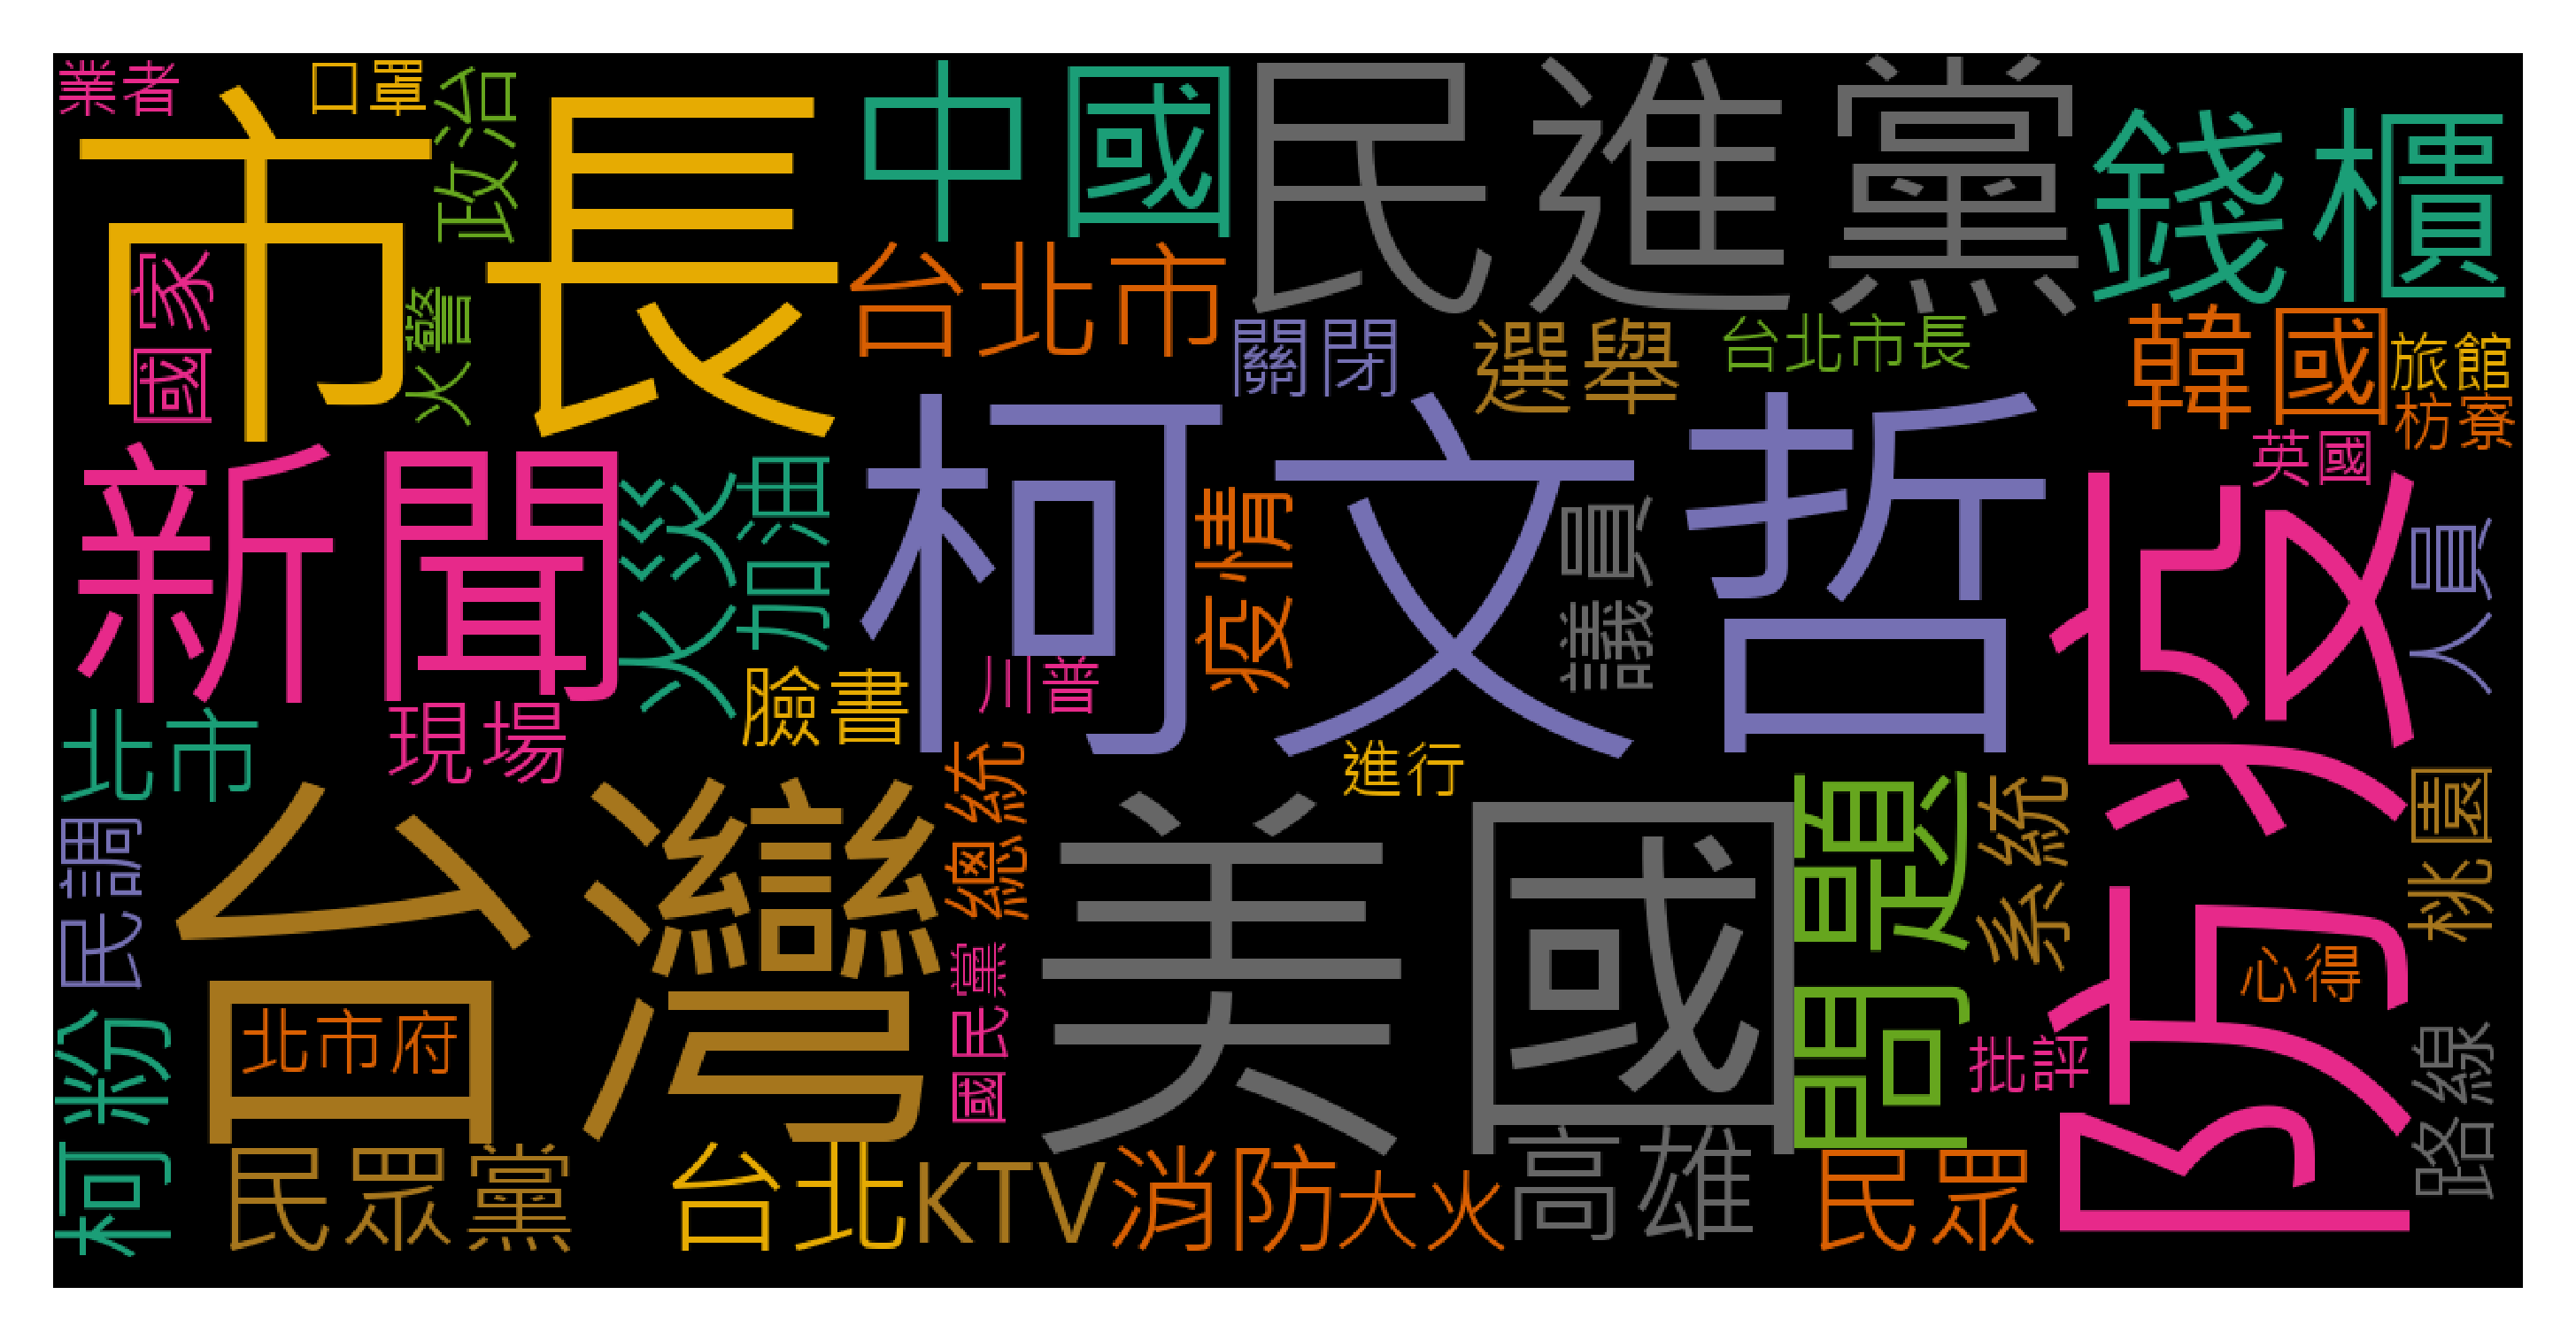

In [36]:
wordcloudPTT(tagsallArticle)

In [26]:
jiebadata = jiebaPTT(pddata_byname, topk=10, OperateF=0, countlen=20)

Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.497 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.495 seconds.
Prefix dict has been built successfully.
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWar

In [27]:
jiebadata

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Rrrxddd,9,市長:23,韓國:18,內政部:17,婦聯會:13,防疫:14,團體:11,高雄:14,政黨:10,盧秀燕:10,北市:9,市長 韓國 內政部 婦聯會 防疫 團體 高雄 政黨 盧秀燕 北市
1,wupaul,9,柯文哲:16,高雄:19,韓國:14,市長:14,大巨蛋:12,民眾黨:12,新聞:11,路線:10,網友:9,台北市:10,柯文哲 高雄 韓國 市長 大巨蛋 民眾黨 新聞 路線 網友 台北市
2,ericisfish,8,阿北:21,KTV:15,關閉:8,錢櫃:7,廣播:7,系統:7,施工:10,檢警:6,如題:5,柯粉:5,阿北 KTV 關閉 錢櫃 廣播 系統 施工 檢警 如題 柯粉
3,TheoEpstein,7,台灣:34,防疫:30,旅館:16,WHO:14,柯文哲:13,日本:29,戴口罩:12,肺炎:16,這是:11,南韓:11,台灣 防疫 旅館 WHO 柯文哲 日本 戴口罩 肺炎 這是 南韓
4,chiangdapang,7,美國:14,中國:12,問題:12,鄭和:11,體系:10,科學:9,歷史:10,國際:9,共產黨:9,法國:9,美國 中國 問題 鄭和 體系 科學 歷史 國際 共產黨 法國
5,coober,7,浪費:7,國王:6,華人:6,華盛頓:5,美國:5,市長:4,中國:4,根本:8,等於:3,問題:3,浪費 國王 華人 華盛頓 美國 市長 中國 根本 等於 問題
6,Fant1408,7,柯粉:10,柯文哲:9,網軍:4,民眾黨:5,練台生:3,練董:3,台北:4,台北人:2,一邊:2,新聞:2,柯粉 柯文哲 網軍 民眾黨 練台生 練董 台北 台北人 一邊 新聞
7,nicholas0406,7,柯文哲:15,時間:12,錢櫃:11,火災:9,嚴重:8,韓粉:8,台北:11,首長:7,上班:11,市政:10,柯文哲 時間 錢櫃 火災 嚴重 韓粉 台北 首長 上班 市政
8,wwHui,6,柯文哲:12,大巨蛋:9,問題:6,台灣:5,資進:4,台北:5,火災:3,KTV:3,這件:3,台北市長:3,柯文哲 大巨蛋 問題 台灣 資進 台北 火災 KTV 這件 台北市長
9,KINMENKING,6,川普:15,英國:15,好過:12,台灣:12,美國:11,蔡英文:10,習近平:9,中國:9,財團:9,歷史:8,川普 英國 好過 台灣 美國 蔡英文 習近平 中國 財團 歷史


In [30]:
pddata_byip.head()

,index,ip,article_author,article_author_len
0,145,1.162.224.197,AIDM;twyes,2
1,216,114.136.90.17,solomn;coober,2
2,77,118.233.86.18,kapasky;isaluku,2
3,274,223.138.210.85,ninebride;sprell,2
4,263,111.82.69.148,KZS;l881125566,2


In [31]:
temp1 = pddata_byname[pddata_byname['article_author']=='AIDM']
temp2 = pddata_byname[pddata_byname['article_author']=='twyes']
art1 = pd.concat([temp1, temp2], axis=0).reset_index()
art1

,level_0,index,article_author,article_content,article_times
0,23,44,AIDM,你媽的我完全看不懂邏輯有人質疑消防人員做事嗎 ?所有這些都跟台北市府監督不周沒關所以大家都在...,4
1,58,186,twyes,基本上你的邏輯錯誤其實我的重點一直沒放在發生火災(除非一點:北市安檢通過結果安全門打不開這點...,3


In [32]:
jiebaart1 = jiebaPTT(art1, topk=10, OperateF=0, countlen=20)
jiebaart1

Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.493 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.473 seconds.
Prefix dict has been built successfully.
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWar

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,AIDM,4,選舉:20,柯文哲:13,高雄:11,柯屁:8,你媽:7,動作:6,防疫:6,蔡璧如:5,藍綠:4,重點:4,選舉 柯文哲 高雄 柯屁 你媽 動作 防疫 蔡璧如 藍綠 重點
1,twyes,3,選舉:16,藍綠:8,柯屁:7,高雄:7,防疫:6,北市:4,火災:4,批評:3,跑去:3,旅館:3,選舉 藍綠 柯屁 高雄 防疫 北市 火災 批評 跑去 旅館


In [33]:
temp1 = pddata_byname[pddata_byname['article_author']=='solomn']
temp2 = pddata_byname[pddata_byname['article_author']=='coober']
art2 = pd.concat([temp1, temp2], axis=0).reset_index()
art2

,level_0,index,article_author,article_content,article_times
0,131,188,solomn,先備份網軍捏造沒發生的事想帶風向比較有建設性的監督應該是舉出施政哪裡有不足要改進例如政府機關...,1
1,5,57,coober,這事情下周就會決生死了如果柯照過往一貫的做法喜歡在輿論與媒體面前秀那就等於開啟了罷免的序幕如...,7


In [34]:
jiebaart2 = jiebaPTT(art2, topk=10, OperateF=0, countlen=20)
jiebaart2

Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.600 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.507 seconds.
Prefix dict has been built successfully.
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWar

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,solomn,1,重點:4,業者:3,2020:3,臺灣:3,執政:2,市長:2,DPP:2,編輯:2,coober:2,大火:2,重點 業者 2020 臺灣 執政 市長 DPP 編輯 coober 大火
1,coober,7,浪費:7,國王:6,華人:6,華盛頓:5,美國:5,市長:4,中國:4,根本:8,等於:3,問題:3,浪費 國王 華人 華盛頓 美國 市長 中國 根本 等於 問題


In [75]:
temp1 = pddata_byname[pddata_byname['article_author']=='ninebride']
temp2 = pddata_byname[pddata_byname['article_author']=='sprell']
art3 = pd.concat([temp1, temp2], axis=0).reset_index()
art3

,level_0,index,article_author,article_content,article_times
0,142,96,ninebride,楊秋興 還沒離開dpp時 中間選民罵得多難聽 所以要選票唾棄他 離開dpp後 中間選民...,1
1,99,141,sprell,所以這就很清楚了吧 也可以印證另一件事 說要投黃國昌 或者林淑芬是良心 最後幾乎都投...,1


In [76]:
jiebaart3 = jiebaPTT(art3, topk=10, OperateF=0, countlen=20)
jiebaart3

Building prefix dict from C:\Users\LoVeU\Documents\GitHub\2nd-PyCrawlerMarathon\homework\Marathon\For_jieba\dict.txt ...
Loading model from cache C:\Users\LoVeU\AppData\Local\Temp\jieba.u95f6187e7824b7d9926ee39e6bf2d3eb.cache
Loading model cost 0.535 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\LoVeU\Documents\GitHub\2nd-PyCrawlerMarathon\homework\Marathon\For_jieba\dict.txt ...
Loading model from cache C:\Users\LoVeU\AppData\Local\Temp\jieba.u95f6187e7824b7d9926ee39e6bf2d3eb.cache
Loading model cost 0.548 seconds.
Prefix dict has been built successfully.
C:\Users\LoVeU\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LoVeU\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,ninebride,1,楊秋興:5,中間:4,選民:4,離開:2,dpp:2,能力:3,得多:1,難聽:1,選票:1,唾棄:1,楊秋興 中間 選民 離開 dpp 能力 得多 難聽 選票 唾棄
1,sprell,1,最後:3,大數據:2,專家:2,這就:1,印證:1,黃國昌:1,林淑芬:1,幾乎:1,kmt:1,高虹安:1,最後 大數據 專家 這就 印證 黃國昌 林淑芬 幾乎 kmt 高虹安


In [11]:
pdtwit_byname

,index,push_userid,push_content,push_times
0,127,chiangdapang,"這是反串嗎?;邱淑緹翻版?;零確診可以振奮醫護的士氣,但是會讓民眾鬆懈;連明朝也可以捧,真的...",189
1,206,alexrow,這篇反串露餡了;不爽不要做;逃生門不重要?;濃煙密布躲室內??? 哪邊的教學?;逃生門打不開...,171
2,18,saiyuki1412,韓國瑜之前好像也有跑去火災現場摸來摸去;之後沒有的話你要以死謝罪嗎;也才剛發生五小時ㄅ;去刷...,154
3,2,Moratti,求救的人有救出來嗎;亂丟菸蒂的也是混蛋;不然要你黃33幹嘛;還好 不是晚上 不然更多人逃不出...,145
4,486,u5710587,阿就推測而已 證據拿出來啊;有證據就一刀斃命嘛;整天在那邊推測;這個什麼夫的連證據都沒有就在...,131
5,19,Xceberus,假日排個選舉行程過份嗎;好詩 好詩;樓上在說江米達喔;老實說根本沒人想看你文章啊;印象中你...,129
6,10,kisc91389,安檢合格結果大火 台北市真優秀;打擾了我們柯市長南下拜廟的好心情;好朋友們持續拿小豬和0確診...,120
7,45,saisai34,這要究責什麼? 業者自行關閉消防設備 然後要檢討公務員;不可能這樣搞的 只能想辦法去防止未來...,83
8,42,cycutom,是她選區的？= =;胖周瑜：你知道柯糞會把桃園隨便一間民宅火災新聞貼上來;罵我嗎？;從柯糞+...,82
9,210,chong17,有消防法規 有權可以管啊！你是反串喔;到假日 市長轉變黨主席;錯了 柯是去屏東;33累死...,81


In [12]:
jiebatwit = jiebaPTT(pdtwit_byname, topk=10, OperateF=0, countlen=20)
jiebatwit

Building prefix dict from C:\Users\LoVeU\Documents\GitHub\2nd-PyCrawlerMarathon\homework\Marathon\For_jieba\dict.txt ...
Loading model from cache C:\Users\LoVeU\AppData\Local\Temp\jieba.u95f6187e7824b7d9926ee39e6bf2d3eb.cache
Loading model cost 0.563 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\LoVeU\Documents\GitHub\2nd-PyCrawlerMarathon\homework\Marathon\For_jieba\dict.txt ...
Loading model from cache C:\Users\LoVeU\AppData\Local\Temp\jieba.u95f6187e7824b7d9926ee39e6bf2d3eb.cache
Loading model cost 0.553 seconds.
Prefix dict has been built successfully.
C:\Users\LoVeU\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LoVeU\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chiangdapang,189,中國:18,階級:14,國家:13,歷史:9,資產:8,社會:7,台灣:6,資本主義:6,鄭和:6,封建:10,中國 階級 國家 歷史 資產 社會 台灣 資本主義 鄭和 封建
1,alexrow,171,論文:9,逃生:8,逃生門:5,濃煙:5,光頭:5,博士:8,支那:5,室內:4,為啥:4,XDDD:4,論文 逃生 逃生門 濃煙 光頭 博士 支那 室內 為啥 XDDD
2,saiyuki1412,154,時力:9,偏鄉:7,民進黨:6,柯文哲:5,倒是:4,有點:4,幹嘛:4,還好:4,路線:4,柯粉:4,時力 偏鄉 民進黨 柯文哲 倒是 有點 幹嘛 還好 路線 柯粉
3,Moratti,145,民進黨:33,時代:17,時粉:12,國民黨:9,捐款:12,力量:17,33:6,捐給:6,黃國昌:5,屏東:5,民進黨 時代 時粉 國民黨 捐款 力量 33 捐給 黃國昌 屏東
4,u5710587,131,韓國:13,柯文哲:9,罷免:8,保證:6,證據:5,蔡英文:5,海龜:5,民進黨:5,左營:5,三山:6,韓國 柯文哲 罷免 保證 證據 蔡英文 海龜 民進黨 左營 三山
5,Xceberus,129,..:0,柯粉:6,台灣:5,GMIGrwn:4,可怕:6,首都:6,北市:3,市民:6,樓上:3,燒死:3,.. 柯粉 台灣 GMIGrwn 可怕 首都 北市 市民 樓上 燒死
6,kisc91389,120,高雄:18,黃珊珊:10,柯文哲:9,柯粉:8,台北:11,市長:5,確診:5,笑死:5,公關:5,好朋友:4,高雄 黃珊珊 柯文哲 柯粉 台北 市長 確診 笑死 公關 好朋友
7,saisai34,83,路線:7,台灣:6,問題:5,公車:5,關閉:4,警報:4,店員:4,看起來:4,意義:4,數據:4,路線 台灣 問題 公車 關閉 警報 店員 看起來 意義 數據
8,cycutom,82,桃園:10,火災:10,柯糞:10,業者:10,XDD:8,鄭文燦:7,市長:7,台北:8,工廠:5,XDDD:5,桃園 火災 柯糞 業者 XDD 鄭文燦 市長 台北 工廠 XDDD
9,chong17,81,柯文哲:16,韓國:7,33:5,公共:7,市長:4,性質:4,營利:4,黨務:3,安檢:3,運輸:3,柯文哲 韓國 33 公共 市長 性質 營利 黨務 安檢 運輸


In [85]:
pdtwit_byip

,index,push_ipdatetime,push_userid,push_userid_len
0,0,04/26,VWVIl1;akway;Moratti;ct412133;jazz19860929;Gre...,685
1,147,04/25,RIFF;JoeStrummer;kisc91389;larusa;xamous;solom...,381
2,26,03/21,z739;wcm;henryliao;jerrylin;mlnaml123;JimJimJim,6
3,1,01/14,cutbear123;goetze;Stigmata;ninaman;devidevi,5
4,2,01/15,bnb89225;formatted;sdg235;RW2010,4
5,3,01/16,DCHC;cutbear123;wjlai0502;S52R,4
6,17,02/03,abm311;aaa11334;x001611,3
7,41,05/08,rtyujlk;su4vu6;shefu120,3
8,35,04/07,awerte;a7788783;NaTaO3,3
9,43,05/11,rtyujlk;ViktorGoogle;v128w,3


In [44]:
jiebatwit = jiebaPTT(pdtwit_byname, topk=10, OperateF=0, countlen=20)

Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.528 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\jason.ho\Documents\Python Scripts\D025\For_jieba\dict.txt ...
Loading model from cache C:\Users\jason.ho\AppData\Local\Temp\jieba.u9afd5bfd2935137a3b762a62a49c73f3.cache
Loading model cost 0.505 seconds.
Prefix dict has been built successfully.
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jason.ho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWar

In [45]:
jiebatwit

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Xceberus,345,柯粉:21,北市:10,笑死:10,..:0,台灣:9,燒死:8,阿北:7,工程師:7,柯文哲:6,王浩宇:6,柯粉 北市 笑死 .. 台灣 燒死 阿北 工程師 柯文哲 王浩宇
1,stesome,313,邏輯:8,民進黨:8,火災:8,柯粉:7,Xceberus:7,台派:7,預知:7,賤畜:6,33:6,台北:8,邏輯 民進黨 火災 柯粉 Xceberus 台派 預知 賤畜 33 台北
2,Moratti,309,民進黨:40,柯粉:22,時代:18,時粉:13,師傅:10,國民黨:10,捐款:12,力量:18,根本:17,新聞:7,民進黨 柯粉 時代 時粉 師傅 國民黨 捐款 力量 根本 新聞
3,chiangdapang,283,中國:26,國家:15,階級:14,鄭和:11,歷史:10,社會:8,資產:8,學生:7,運河:7,經濟:7,中國 國家 階級 鄭和 歷史 社會 資產 學生 運河 經濟
4,cycutom,243,桃園:25,柯糞:25,瞎話:18,睜眼:17,鄭文燦:16,笑死:16,業者:14,安檢:12,消防員:12,市長:11,桃園 柯糞 瞎話 睜眼 鄭文燦 笑死 業者 安檢 消防員 市長
5,foolfighter,219,柯糞:32,滿意度:15,師父:14,柯文哲:13,民調:12,可憐:9,廢物:9,白痴:9,韓國:7,柯狗:6,柯糞 滿意度 師父 柯文哲 民調 可憐 廢物 白痴 韓國 柯狗
6,saiyuki1412,180,時力:10,偏鄉:7,民進黨:6,柯文哲:5,韓國:4,還好:4,路線:4,柯粉:4,小編:4,公車:4,時力 偏鄉 民進黨 柯文哲 韓國 還好 路線 柯粉 小編 公車
7,alexrow,159,論文:9,逃生:8,逃生門:5,濃煙:5,光頭:5,博士:8,室內:4,為啥:4,時力:4,捐多少:4,論文 逃生 逃生門 濃煙 光頭 博士 室內 為啥 時力 捐多少
8,serval623,142,柯粉:33,立委:8,阿北:9,柯神:8,練台生:6,..:0,鄭文燦:5,老闆:5,綠營:5,果凍:5,柯粉 立委 阿北 柯神 練台生 .. 鄭文燦 老闆 綠營 果凍
9,u5710587,131,韓國:13,柯文哲:9,罷免:8,保證:6,證據:5,蔡英文:5,海龜:5,民進黨:5,左營:5,三山:6,韓國 柯文哲 罷免 保證 證據 蔡英文 海龜 民進黨 左營 三山


In [6]:
# 抓之前爬過後已整理好的檔案
crawlTest = CrawlPTT(PTT_URL)
crawlTest.loadPreCrawl()
pddata_byname, pddata_byip, pdtwit_byname, pdtwit_byip = crawlTest.collectCommend()

In [39]:
len(crawlTest.data)

537